In [57]:
from google.colab import userdata
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math
import random

from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [58]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d mujtabamatin/air-quality-and-pollution-assessment

! unzip "air-quality-and-pollution-assessment.zip"


Dataset URL: https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment
License(s): apache-2.0
air-quality-and-pollution-assessment.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  air-quality-and-pollution-assessment.zip
replace updated_pollution_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: updated_pollution_dataset.csv  


(5000, 8)


Text(0.5, 1.0, 'Decision Tree')

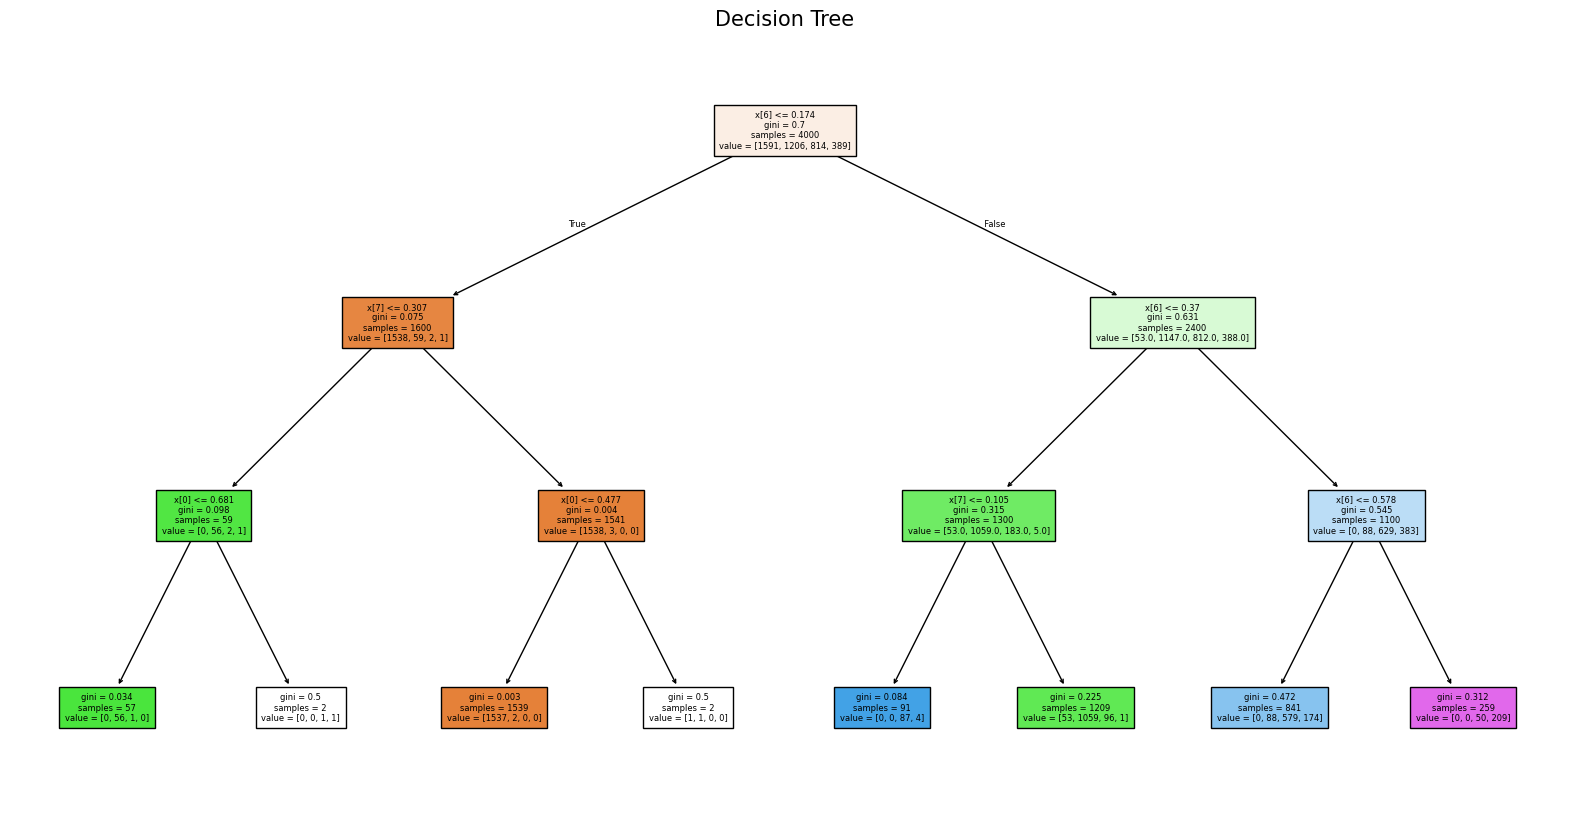

In [59]:
data_path = "/content/updated_pollution_dataset.csv"

data = pd.read_csv(data_path)
scaler = MinMaxScaler()

data_normalized = np.array(data)[:, :-1]
data_normalized = scaler.fit_transform(data_normalized)

X, Y = np.array(data_normalized)[:, :-1], np.array(data)[:, -1]
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

def map_quality(quality):
    if quality == 'Good':
        return 1
    elif quality == 'Moderate':
        return 2
    elif quality == 'Poor':
        return 3
    elif quality == 'Hazardous':
        return 4

vectorized_map_quality = np.vectorize(map_quality)

y_train = vectorized_map_quality(y_train)
y_test = vectorized_map_quality(y_test)

clf = tree.DecisionTreeClassifier(random_state = 42, max_depth=3)
clf = clf.fit(x_train, y_train)

plt.figure(figsize=(20, 10))
tree.plot_tree(clf, filled=True, fontsize=6)
plt.title("Decision Tree", fontsize=15)

In [60]:
class DecisionNode:
    def __init__(self, feature_index= None, threshold = None, left = None, right = None, value = None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth = None, gain = None, drop_set_size = None,  max_features = None):
        self.max_depth = max_depth
        self.gain = gain
        self.drop_set_size = drop_set_size
        self.root = None
        self.current_max_depth = 0
        self.max_features = max_features

    def fit(self, X, Y):
        self.root = self._build_tree(X, Y)

    def _build_tree(self, X, Y, depth = 0):
        num_samples, num_features = X.shape
        unique_classes = np.unique(Y)

        if len(unique_classes) == 1 or (self.max_depth is not None and depth == self.max_depth) or (self.drop_set_size is not None and len(Y) <= self.drop_set_size):
            return DecisionNode(value=self._most_common_class(Y))

        best_feature_index, best_threshold, best_gain = self._best_split(X, Y)


        if best_feature_index is None or (self.gain is not None and best_gain < self.gain):
            return DecisionNode(value=self._most_common_class(Y))

        if self.current_max_depth < depth:
          self.current_max_depth = depth

        left_indices = X[:, best_feature_index] < best_threshold
        right_indices = X[:, best_feature_index] >= best_threshold

        left_node = self._build_tree(X[left_indices], Y[left_indices], depth + 1)
        right_node = self._build_tree(X[right_indices], Y[right_indices], depth + 1)

        return DecisionNode(feature_index=best_feature_index, threshold=best_threshold, left=left_node, right=right_node)

    def _best_split(self, X, Y):
        num_samples, num_features = X.shape
        best_gain = float('-inf')
        best_feature_index = None
        best_threshold = None

        if self.max_features == "sqrt":
          features = int(math.sqrt(num_features))
          num_features = random.sample(range(0, num_features), features)
        else:
           num_features = list(range(num_features))

        for feature_index in num_features:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = X[:, feature_index] >= threshold

                if len(Y[left_indices]) == 0 or len(Y[right_indices]) == 0:
                    continue

                gain = self._gain_(Y, Y[left_indices], Y[right_indices])

                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold, best_gain

    def _gini_(self, S):
        unique_classes = np.unique(S)
        sum_probabilities = 0
        total_samples = len(S)

        for class_ in unique_classes:
            p = np.sum(S == class_) / total_samples
            sum_probabilities += p ** 2

        return 1 - sum_probabilities

    def _gain_(self, S, *S_i):
        total_samples = len(S)
        sum_gain = self._gini_(S)

        for s_i in S_i:
            sum_gain += len(s_i) * self._gini_(s_i) / total_samples

        return self._gini_(S)  - sum_gain

    def _most_common_class(self, y):
        count = Counter(y)
        return count.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._predict_sample(sample) for sample in X])

    def _predict_sample(self, sample):
        node = self.root
        while node.value is None:
            if sample[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

In [61]:
criteria = ['gini', 'entropy', 'log_loss']
result_train = []
result_test = []

for cr in criteria:
  library_tree = tree.DecisionTreeClassifier(criterion = cr)
  library_tree.fit(x_train, y_train)
  height = library_tree.tree_.max_depth

  result = library_tree.predict(x_train)
  accuracy = accuracy_score(result, y_train)
  result_train.append([cr, height, accuracy])

  result = library_tree.predict(x_test)
  accuracy = accuracy_score(result, y_test)
  height = library_tree.tree_.max_depth
  result_test.append([cr, height, accuracy])

In [62]:
result_train = []
result_test = []

result_train_my = []
result_test_my = []
min_samples_split = random.sample(range(5, 1000), 10)

for split in min_samples_split:
  library_tree = tree.DecisionTreeClassifier(min_samples_split = split)
  library_tree.fit(x_train, y_train)

  result = library_tree.predict(x_train)
  accuracy = accuracy_score(result, y_train)
  height = library_tree.tree_.max_depth
  result_train.append((split, height, accuracy))

  result = library_tree.predict(x_test)
  accuracy = accuracy_score(result, y_test)
  height = library_tree.tree_.max_depth
  result_test.append((split, height, accuracy))

  my_tree = DecisionTree(drop_set_size = split)
  my_tree.fit(x_train, y_train)

  result = my_tree.predict(x_train)
  accuracy = accuracy_score(result, y_train)
  height = my_tree.current_max_depth
  result_train_my.append((split, height, accuracy))

  result =  my_tree.predict(x_test)
  accuracy = accuracy_score(result, y_test)
  height = my_tree.current_max_depth
  result_test_my.append((split, height, accuracy))


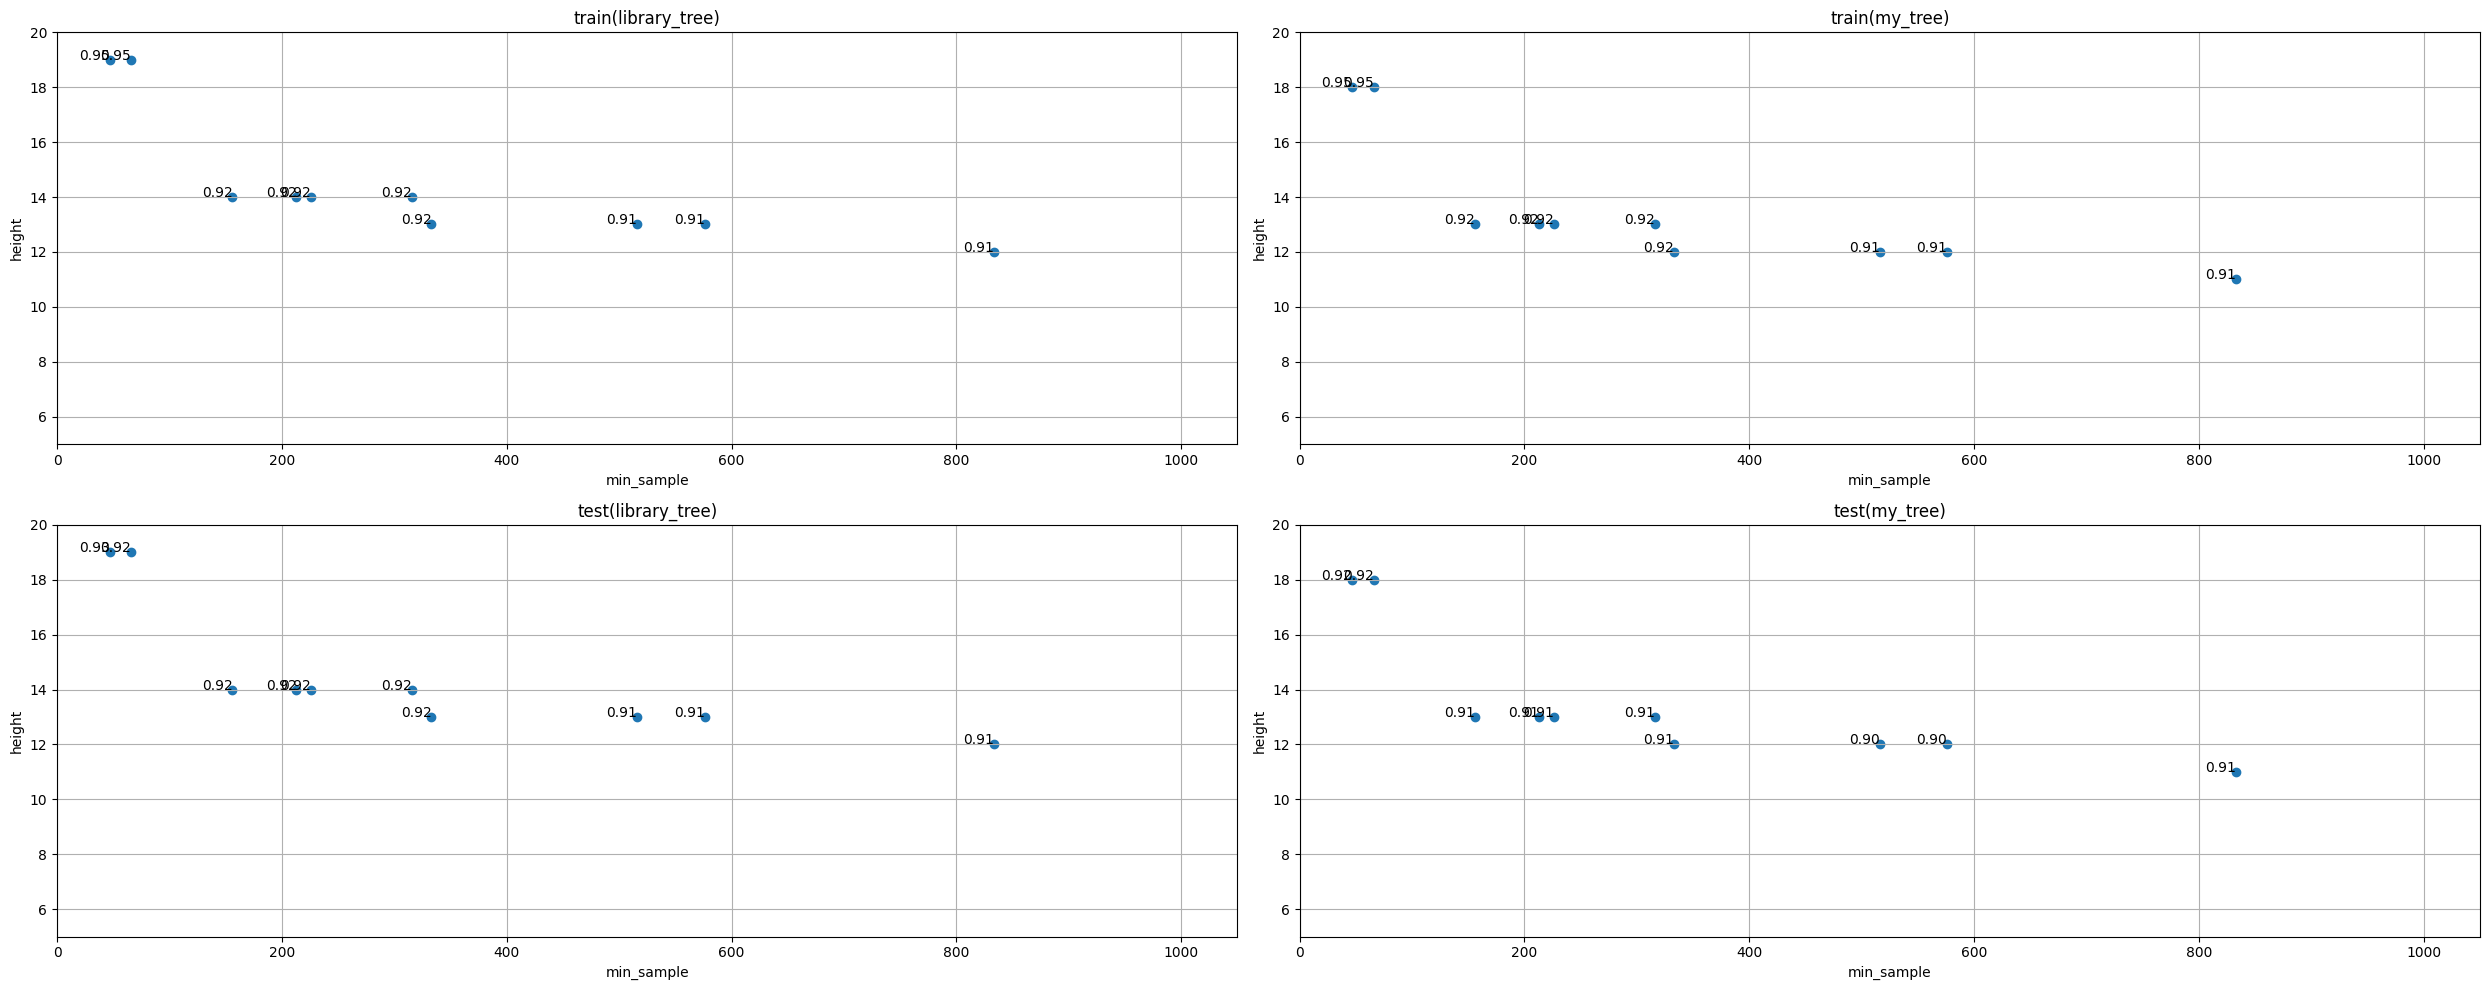

In [63]:
def plot_min_split(data, title, subplot_position, label = False):
  x = [float(item[0]) for item in data]
  y = [float(item[1]) for item in data]

  if label:
    labels = [float(item[2]) for item in data]

  plt.subplot(2, 2, subplot_position)
  plt.scatter(x, y)

  if label:
    for i in range(len(x)):
        plt.text(x[i], y[i], f'{labels[i]:.2f}', fontsize=10, ha='right')
  else:
    for i in range(len(x)):
        plt.text(x[i], y[i], '',fontsize=5)

  plt.title(title)
  if label:
    plt.xlabel('min_sample')
    plt.ylabel('height')
  else:
    plt.xlabel('estimators')
    plt.ylabel('p')
  plt.grid()
  if label:
    plt.xlim(0, 1050)
    plt.ylim(5, 20)
  else:
    plt.xlim(0, 20)
    plt.ylim(0, 1.01)

plt.figure(figsize=(25, 10))
plot_min_split(result_train, 'train(library_tree)', 1, True)
plot_min_split(result_train_my, 'train(my_tree)', 2, True)
plot_min_split(result_test, 'test(library_tree)', 3, True)
plot_min_split(result_test_my, 'test(my_tree)', 4, True)

plt.tight_layout()
plt.show()

In [64]:
class RandomForest:
  def __init__(self, trees_count = None, max_depth = None, gain = None, drop_set_size = None,  max_features = "sqrt"):
    self.trees_count = trees_count
    self.max_depth = max_depth
    self.gain = gain
    self.drop_set_size = drop_set_size
    self.root = None
    self.current_max_depth = 0
    self.max_features = max_features
    self.trees = []

  def _boostrap_(self, X, Y):
    indices = np.random.choice(len(X), len(X), replace=True)
    return X[indices], Y[indices]

  def fit(self, X, Y):
    for tree in range(self.trees_count):
      decisionTree = DecisionTree(max_depth = self.max_depth, gain = self.gain,
                                  drop_set_size = self.drop_set_size, max_features = self.max_features)
      x_train, y_train = self._boostrap_(X, Y)

      decisionTree.fit(x_train, y_train)
      self.trees.append(decisionTree)


  def predict(self, X):
    answers = []
    for tree in self.trees:
      answers.append(tree.predict(X))

    most_common_numbers = []
    for i in range(len(answers[0])):

      current_position_numbers = [arr[i] for arr in answers]

      counter = Counter(current_position_numbers)

      most_common_number, count = counter.most_common(1)[0]

      most_common_numbers.append(most_common_number)
    return most_common_numbers

In [65]:
result_train = []
result_test = []

result_train_my = []
result_test_my = []
estimators = random.sample(range(1, 20), 5)

for estimator in estimators:
  library_tree = RandomForestClassifier(n_estimators = estimator)
  library_tree.fit(x_train, y_train)

  result = library_tree.predict(x_train)
  accuracy = accuracy_score(y_train, result)
  result_train.append((estimator, accuracy))

  result = library_tree.predict(x_test)
  accuracy = accuracy_score(y_test, result)
  result_test.append((estimator, accuracy))

  my_tree = RandomForest(trees_count = estimator)
  my_tree.fit(x_train, y_train)

  result = my_tree.predict(x_train)
  accuracy = accuracy_score(y_train, result)
  result_train_my.append((estimator, accuracy))

  result = my_tree.predict(x_test)
  accuracy = accuracy_score(y_test, result)
  result_test_my.append((estimator, accuracy))

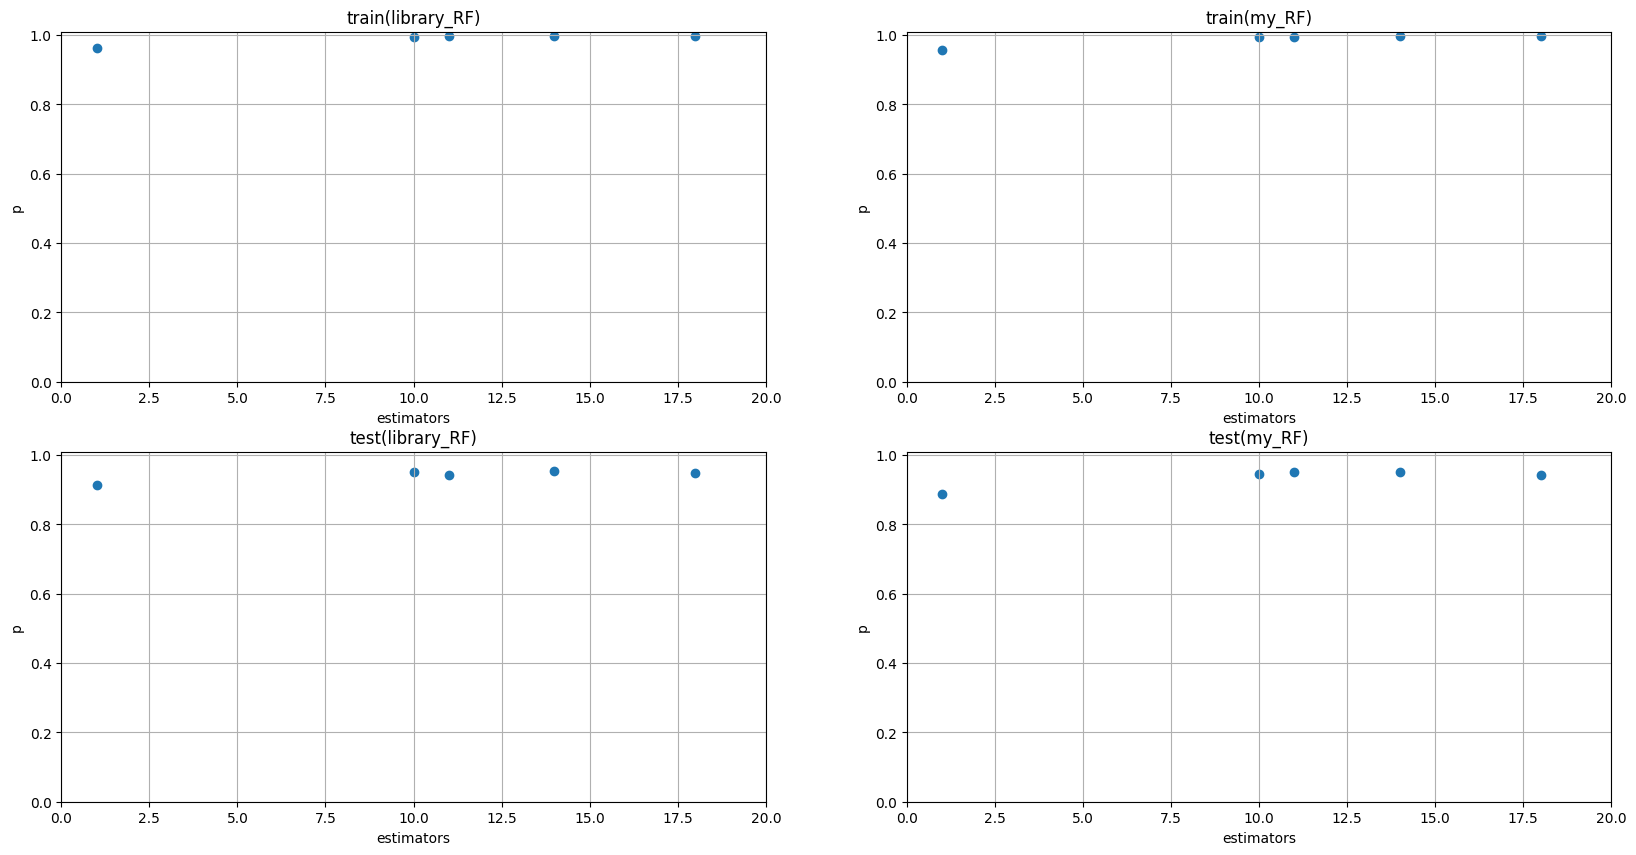

In [66]:
plt.figure(figsize=(20, 10))

plot_min_split(result_train, 'train(library_RF)', 1)
plot_min_split(result_train_my, 'train(my_RF)', 2)
plot_min_split(result_test, 'test(library_RF)', 3)
plot_min_split(result_test_my, 'test(my_RF)', 4)